In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import csv
import cv2
import math

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
dir = '../input/airbus-ship-detection/'

# **Training data**

In [12]:
train_df = pd.read_csv(dir + "train_ship_segmentations_v2.csv")
train_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


## Count Ships

In [13]:
train_df['ShipCount'] = train_df.groupby('ImageId')['ImageId'].transform('count')
train_df.loc[train_df['EncodedPixels'].isnull().values,'ShipCount'] = 0

In [14]:
train_df

,ImageId,EncodedPixels,ShipCount
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [15]:
count_df = train_df.groupby('ShipCount').count()
count_df

,ImageId,EncodedPixels
ShipCount,,
0,150000,0
1,27104,27104
2,15348,15348
3,8862,8862
4,6488,6488
5,4625,4625
6,3942,3942
7,2842,2842
8,2544,2544


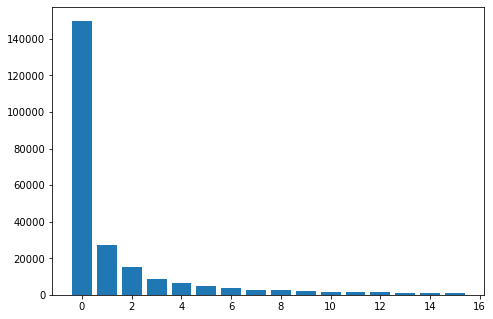

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(count_df.index.values.tolist(), list(count_df['ImageId']))
plt.show()

# Image Enhancement

In [17]:
sampleList = ['001aee007.jpg','001234638.jpg','001f04ca3.jpg','000d26c17.jpg']
sampleImgList = []
for x in sampleList:
    sampleImgList.append(mpimg.imread(dir + 'train_v2/' + x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


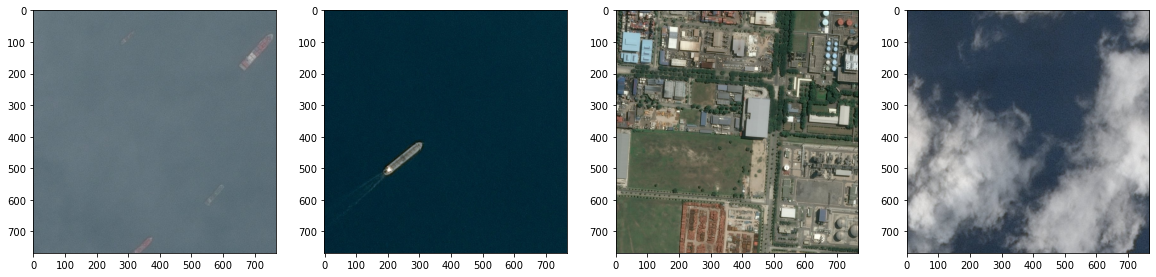

In [18]:
fig = plt.figure(1,figsize=(20,10))
for i in range(len(sampleImgList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)

In [19]:
from skimage.feature import canny
from skimage.filters import scharr, unsharp_mask
from skimage import exposure
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value

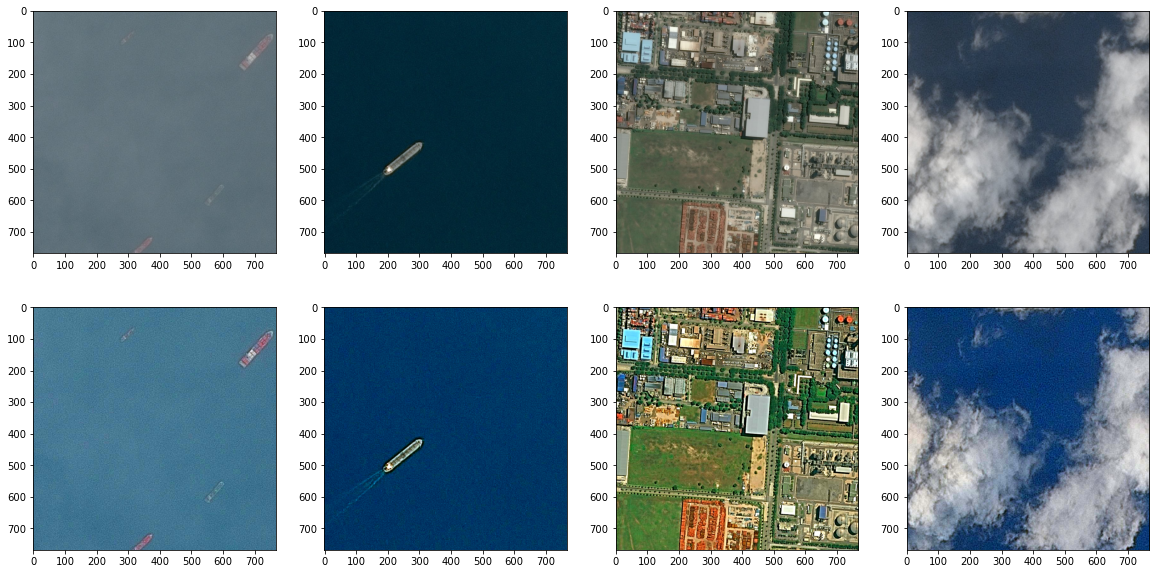

In [20]:
fig = plt.figure(1,figsize=(20,20))
for i in range(len(sampleImgList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(image_tmp)
    image_tmp = unsharp_mask(sampleImgList[i], radius=4, amount=2)
    sampleImgList[i] = image_tmp
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)

# Decoding the pixels

In [86]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def get_all_masks(image_id):
    ret = []
    s = train_df[train_df['ImageId'] == image_id]['EncodedPixels']
    if not s.isnull().values.any():
        for x in s:
            ret.append(rle_to_pixels(x))
    return ret

def show_masks(image_id):
    canvas = np.zeros((768, 768))
    masks = get_all_masks(image_id)
    for x in masks:
       canvas[tuple(zip(*x))] = 1
    return canvas

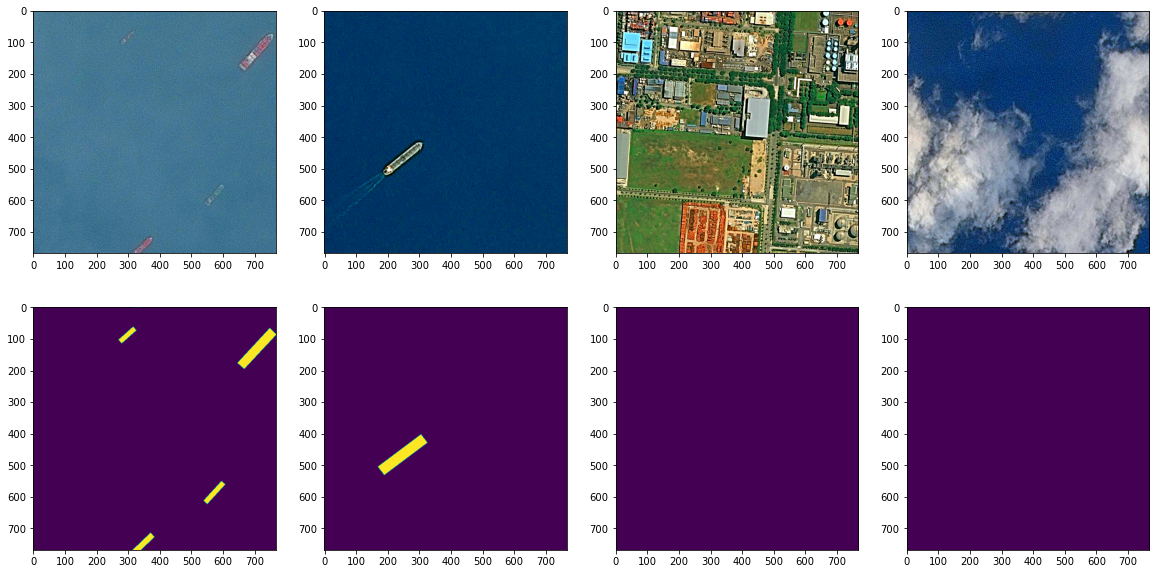

In [88]:
fig = plt.figure(1,figsize=(20,20))
for i in range(len(sampleList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(image_tmp)
    image_tmp = show_masks(sampleList[i])
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)